# 20OCT Factory Day Demo

This is a demonstration notebook to illustrate the use of the MLTE library and SDMT process for Factory Day. This demo uses the "Dogs vs. Cats" dataset and scenario from the Factory Day negotiation exercise as guidance for the required Properties and Conditions.

## 0. Quality Attribute Scenarios

The following is a prioritized (but limited) list of the QASs that we want to validate through the use of MLTE. The examples below relate to the hypothetical system used by the Dogs are Dumb (DaD) Task Force to detect non-compliant service members who own dogs. The system used an ML model that was trained on the cats and dogs dataset located on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). 

* **Precision**
  * Beause the DaD cares about identifing dogs but NEVER missclassifying a cat as a dog (false posiive), this model will need to have a high precision. Precision is measured as the true positive rate divided by the true positive rate times the false positive rate. 
* **Robustness- Model Robust to Noise (Image Blur)**
  * Because the model will receive pictures taken from a device mounted on the back of a cat, they will likely be a bit blurry. The model should still be able to successfully identify dogs at the same rate as non-blurry images. Test data needs to include blurred images.  Blurred images will be created using ImageMagick. For our purposes we will test against maximum blur. Blurry images are successfully identified at rates equal to that of non-blurred images. This will be measured using the Wilcoxon Rank-Sum test, with significance at p-value <=0.05.
* **Performance on Operational Platform**
  * The model will need to run on devices worn on the back of cats. These are small, inexpensive devices with limited CPU power, as well as limited memory and disk space (512 MB and 128 GB, respectively). The original test dataset can be used. 1- Executing the model on the loaned platform will not exceed maximum CPU usage of 30% to ensure reasonable response time. CPU usage will be measure using ps. 2- Memory usage at inference time will not exceed available memory of 512 MB. This will be measured using pmap. 3 - Disk usage will not exceed available disk space of 128 GB. This will be measured using by adding the size ofå each file in the path for the model code.

## 1. Define a Specification

In the first phase of SDMT, we define a `Specification` that represents the requirements the completed model must meet in order to be acceptable for use in the system into which it will be integrated.

### 1.1 Initialize MLTE Context

MLTE contains a global context that manages the currently active _session_. Initializing the context tells MLTE how to store all of the artifacts that it produces. Install MLTE if not done already

In [50]:
#!pip install mlte-python==0.2.2

In [51]:
import os
from mlte.session import set_context, set_store

store_path = os.path.join(os.getcwd(), "store")
os.makedirs(store_path, exist_ok=True)   # Ensure we are creating the folder if it is not there.

set_context("ns", "DogsVCats", "0.0.1")
set_store(f"local://{store_path}")

### 1.2 Construct a Negotiation Card

In the exercise, you negotiated the requirements for the model and system. MLTE provides an artifact that assists in this process - the `Negotiation Card`.

In [52]:
from mlte.negotiation.artifact import NegotiationCard
from mlte.model.shared import (
    MetricDescriptor,
    DataDescriptor,
    DataClassification,
    FieldDescriptor,
    LabelDescriptor,
    ModelDescriptor,
    ModelDevelopmentDescriptor,
    ModelResourcesDescriptor,
    ModelProductionDescriptor,
    ModelInterfaceDescriptor,
    ModelInputDescriptor,
    ModelOutputDescriptor,
)
from mlte.negotiation.model import (
    SystemDescriptor,
    GoalDescriptor,
    ProblemType,
    RiskDescriptor,
)

card = NegotiationCard(
    system=SystemDescriptor(
        goals=[
            GoalDescriptor(
                description="The model should precicesly identify dogs",
                metrics=[
                    MetricDescriptor(
                        description="Accuracy",
                        baseline="Greater than .7",
                    )
                ],
            )
        ],
        problem_type=ProblemType.CLASSIFICATION,
        task="Dog Identification",
        usage_context="A dog identification device mounted on the back of a cat.",
        risks=RiskDescriptor(
            fp="A cat is identified as a dog; This is critical to avoid becuase an innoncent cat owning service member will be falsely convicted",
            fn="A service member owning a dog will slip through the cracks",
            other="N/A",
        ),
    ),
    data=[
        DataDescriptor(
            description="Dogs v Cats; The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.",
            classification=DataClassification.UNCLASSIFIED,
            access="None",
            fields=[
                FieldDescriptor(
                    name="Filename with label cat or dog",
                    description="An image depicting a cat or a dog",
                    type="jpg",
                    expected_values="N/A",
                    missing_values="N/A",
                    special_values="N/A",
                )
            ],
            labels=[
                LabelDescriptor(description="cat", percentage=50.0),
                LabelDescriptor(description="dog", percentage=50.0),
            ],
            policies="N/A",
            rights="N/A",
            source="https://www.kaggle.com/c/dogs-vs-cats",
            identifiable_information="N/A",
        )
    ],
    model=ModelDescriptor(
        development=ModelDevelopmentDescriptor(
            resources=ModelResourcesDescriptor(
                cpu="1", gpu="0", memory="512MiB", storage="128GiB"
            )
        ),
        production=ModelProductionDescriptor(
            integration="integration",
            interface=ModelInterfaceDescriptor(
                input=ModelInputDescriptor(description="Vector[150]"),
                output=ModelOutputDescriptor(description="Vector[3]"),
            ),
            resources=ModelResourcesDescriptor(
                cpu="1",
                gpu="0",
                memory="512MiB",
                storage="128GiB",
            ),
        ),
    ),
)
card.save(force=True, parents=True)

### 1.3 Build a `Specification`

In MLTE, we define requirements by constructing a specification (`Spec`). For each property, we define the validations to perform as well. Note that several new `Value` types (`MultipleAccuracy`, `RankSums`, `MultipleRanksums`) had to be created to define the validation methods that will validate each Condition.

In [53]:
from mlte.spec.spec import Spec

# The Properties we want to validate, associated with our scenarios.
from mlte.property.functionality.task_efficacy import TaskEfficacy
from mlte.value.types.real import Real
from mlte.property.costs.storage_cost import StorageCost
from properties.robustness import Robustness
from properties.predicting_memory_cost import PredictingMemoryCost
from properties.predicting_compute_cost import PredictingComputeCost

# The Value types we will use to validate each condition.
from mlte.measurement.storage import LocalObjectSize
from mlte.measurement.cpu import LocalProcessCPUUtilization
from mlte.measurement.memory import LocalProcessMemoryConsumption
from values.confusion_matrix import ConfusionMatrix
from values.ranksums import RankSums

# The full spec.
spec = Spec(properties={
    TaskEfficacy(
            "Important to understand if the model is useful for this case"
        ): {
            "accuracy": Real.greater_or_equal_to(0.8),
            "confusion matrix": ConfusionMatrix.misclassification_count_less_than(
                2
            )
        },
    Robustness("Robust against blur"): 
                {"ranksums blur0x8": RankSums.p_value_greater_or_equal_to(0.05/3)},
    StorageCost("Critical since model will be in an embedded device"): 
                    {"model size": LocalObjectSize.value().less_than(3000)},                
    PredictingMemoryCost("Useful to evaluate resources needed when predicting"): 
                    {"predicting memory": LocalProcessMemoryConsumption.value().average_consumption_less_than(512000.0)},
    PredictingComputeCost("Useful to evaluate resources needed when predicting"): 
                    {"predicting cpu": LocalProcessCPUUtilization.value().max_utilization_less_than(30.0)},
    })
spec.save(parents=True, force=True)

## 2. Initial Model Development

### 2.1 Enviornment Setup

This demo has an additional set of requirements in addition to MLTE. You can install them from the file in this folder, with the command: 

In [54]:
#!pip --default-timeout 1000 install -r requirements.txt

In [55]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot
from matplotlib.image import imread

2.14.0


Define different folders that will be used as input or output for the data gathering process.

In [ ]:
from pathlib import Path

# The path at which datasets are stored
DATASETS_DIR = Path.cwd() / "data"

# Path where the model files are stored.
MODELS_DIR = Path.cwd() / "model"

# The path at which media is stored
MEDIA_DIR = Path.cwd() / "media"
os.makedirs(MEDIA_DIR, exist_ok=True)

### 2.2 Data Preparation

In order to satisfy the requirements defined in the initial negotiation with the DaD TF, you decide to develop a convolution neural network to classify images into two categories, dog or cat. You decide to use a publicly available dataset on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) to train your model. The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.

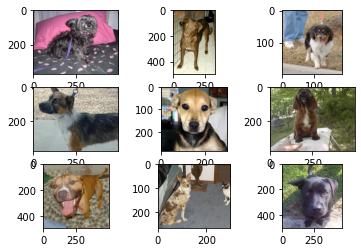

In [56]:
# examples of "dog" images
folder = 'data/train/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

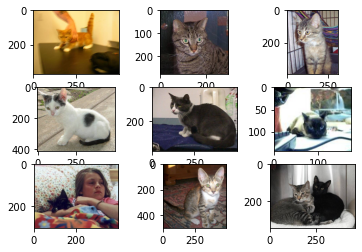

In [57]:
# examples of "cat" images
folder = 'data/train/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

In [58]:
# explore the breakdown of train and test images
training_images = "data/train"
test_images = "data/test"

train_size = len([name for name in os.listdir(training_images)])
test_size = len([name for name in os.listdir(test_images)])
print("Number of training images:", train_size)
print("Number of test images:", test_size)

Number of training images: 25000
Number of test images: 12500


In [59]:
IMAGE_WIDTH = IMAGE_HEIGHT = 150

Prepare file names and training data. Since you are developing a binary classifier, you label the target class of dogs as "1" and cats as "0"

In [60]:
filenames = os.listdir(training_images)
categories = []

Valid_Fraction = 0.2
Batch_Size = 100
Epochs = 100

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
categories = [str(i) for i in categories]
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot: >

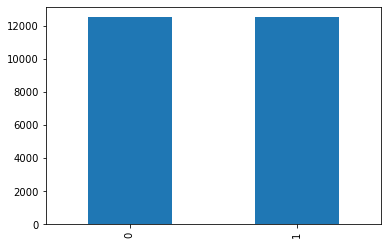

In [61]:
df['category'].value_counts().plot.bar()

In [62]:
# splitting to train & valid
train_df, valid_df = train_test_split(df, test_size=Valid_Fraction, random_state=10)

### 2.3 Generators

In [63]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 20000 validated image filenames belonging to 2 classes.


In [64]:
# not doing any data augmentation on validation test set
valid_datagen  = ImageDataGenerator(rescale=1./255.)

validation_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 5000 validated image filenames belonging to 2 classes.


### 2.5 Training Model

In [65]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [66]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    patience=10)

### 2.6 Training

In [67]:
total_validate = int(valid_df.count()[0])
total_train = int(train_df.count()[0])

In [68]:
history = model.fit_generator(
    train_generator, 
    epochs=Epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//Batch_Size,
    steps_per_epoch=total_train//Batch_Size,
    callbacks=[es]
)

/tmp/ipykernel_11609/2871421910.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
200/200 [==============================] - 216s 1s/step - loss: 0.7518 - accuracy: 0.6370 - val_loss: 2.1045 - val_accuracy: 0.4904
Epoch 2/100
200/200 [==============================] - 205s 1s/step - loss: 0.5482 - accuracy: 0.7294 - val_loss: 2.4596 - val_accuracy: 0.4952
Epoch 3/100
200/200 [==============================] - 210s 1s/step - loss: 0.4824 - accuracy: 0.7689 - val_loss: 0.6696 - val_accuracy: 0.7172
Epoch 4/100
200/200 [==============================] - 221s 1s/step - loss: 0.4407 - accuracy: 0.7970 - val_loss: 1.7082 - val_accuracy: 0.5926
Epoch 5/100
200/200 [==============================] - 246s 1s/step - loss: 0.4134 - accuracy: 0.8088 - val_loss: 0.5072 - val_accuracy: 0.7744
Epoch 6/100
200/200 [==============================] - 240s 1s/step - loss: 0.3918 - accuracy: 0.8228 - val_loss: 0.3202 - val_accuracy: 0.8668
Epoch 7/100
200/200 [==============================] - 226s 1s/step - loss: 0.3717 - accuracy: 0.8332 - val_loss: 0.3529 - val_accuracy:

In [69]:
# serialize model to JSON
model_json = model.to_json()
with open("DogsVCatsv1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DogsVCatsv1.h5")
print("Saved model to disk")

Saved model to disk


### 2.7 Testing Generator

In [70]:
test_filenames = os.listdir(test_images)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [71]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_images, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=Batch_Size,
    shuffle=False
)

Found 12500 validated image filenames.


### 2.8 Predictions on Test Data

In [72]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/Batch_Size))
predict

/tmp/ipykernel_11609/2475604923.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/Batch_Size))


array([[9.7965312e-01],
       [7.4886635e-04],
       [5.0929725e-01],
       ...,
       [9.9505401e-01],
       [1.3588284e-04],
       [8.3880210e-01]], dtype=float32)

As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

In [73]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

<AxesSubplot: >

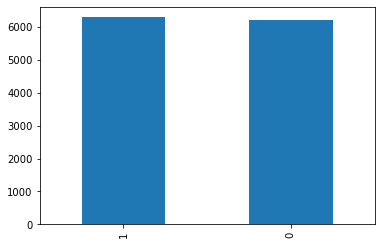

In [74]:
test_df['category'].value_counts().plot.bar()

### 2.9 Visualize Predictions

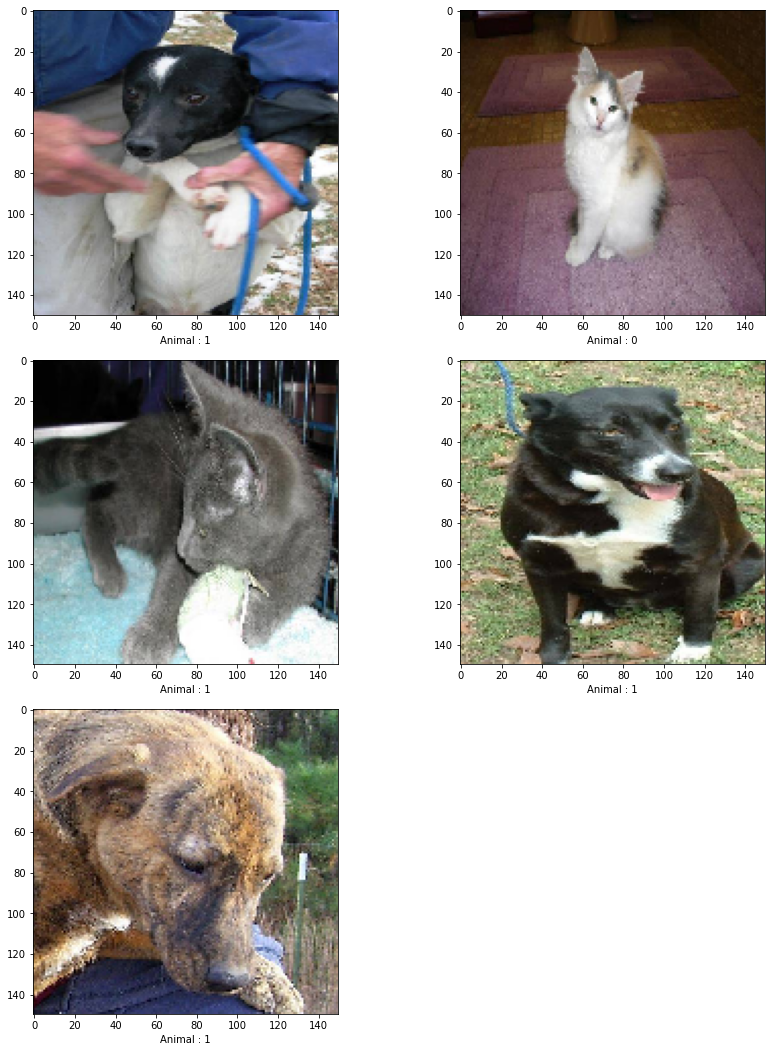

In [75]:
from matplotlib import pyplot as plt

sample_test = test_df.head(5)

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    plt.subplot(5, 2, index+1)
    plt.imshow(img)
    plt.xlabel("Animal : " + str(category))
plt.tight_layout()
plt.show()

In [116]:
predict = model.predict_generator(validation_generator, steps=np.ceil(nb_samples/Batch_Size))

threshold = 0.5
valid_df['probability'] = predict
valid_df['predicted_label'] = np.where(valid_df['probability'] > threshold, 1,0)

save_df = valid_df.copy()
save_df['label'] = np.where(save_df['filename'].str.split('.').str[0] == 'dog', 1, 0)
save_df.drop(['filename', 'probability', 'category'], axis=1, inplace=True)
save_df['model correct'] = np.where(save_df['label'] == save_df['predicted_label'], True, False)

save_df.to_csv('DogsVCatsv1_ValidationResults.csv', index=True)

/tmp/ipykernel_11609/2860777846.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps=np.ceil(nb_samples/Batch_Size))


# 3. Collect Evidence

In the second phase of SDMT, we collect _evidence_ to attest to the fact that the model realized the properties specified in the previous phase.

We define and instantiate `Measurement`s to generate this evidence. Each individual piece of evidence is a `Value`. Once `Value`s are produced, we can persist them to an _artifact store_ to maintain our evidence across sessions. 

### 3.1 Accuracy / Precision

In [115]:
import sklearn.metrics as metrics

from mlte.value.types.real import Real
from mlte.measurement import ExternalMeasurement

predictions = model.predict_generator(validation_generator, steps=total_train//Batch_Size)
predicted_classes = np.where(predictions > .5, 1,0)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Evaluate accuracy
accuracy_measurement = ExternalMeasurement("accuracy", Real, metrics.accuracy_score)
accuracy: Real = accuracy_measurement.evaluate(true_classes, predicted_classes)

# Inspect value
print(accuracy)

# Save to artifact store
accuracy.save(force=True)

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)

/tmp/ipykernel_11609/917797955.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator, steps=total_train//Batch_Size)


0.495


In [111]:
from sklearn.metrics import confusion_matrix
from values.confusion_matrix import ConfusionMatrix
from mlte.measurement import ExternalMeasurement

# Generate value
matrix_measurement = ExternalMeasurement(
    "confusion matrix", ConfusionMatrix, confusion_matrix
)
matrix = matrix_measurement.evaluate(true_classes, predicted_classes)

# Evaluate.
matrix: ConfusionMatrix = matrix_measurement.evaluate(true_classes, predicted_classes)

# Inspect
print(matrix)

# Save to artifact store
matrix.save(force=True)

[[1226 1226]
 [1215 1333]]


### 3.2 Robustness to Image Blur

In [112]:
# General functions.
import pandas as pd
from os import path


def calculate_base_accuracy(df_results: pd.DataFrame) -> pd.DataFrame:
    #Calculate the base model accuracy result per data label
    df_pos = df_results[df_results['model correct'] == True].groupby('label').count()
    df_pos.drop(columns = ['predicted_label'], inplace = True)
    df_neg = df_results[df_results['model correct'] == False].groupby('label').count()
    df_neg.drop(columns = ['predicted_label'], inplace = True)
    df_neg.rename(columns = {'model correct':'model incorrect'}, inplace = True)
    df_res = df_pos.merge(df_neg, right_on ='label', left_on = 'label', how = 'outer')
    df_res.fillna(0, inplace = True)
    df_res['model acc'] = df_res['model correct'] / ( df_res['model correct'] + df_res['model incorrect'] )
    df_res['count'] = ( df_res['model correct'] + df_res['model incorrect'] )
    df_res.drop(columns = ['model correct', 'model incorrect'], inplace = True)
    df_res.head()

    return df_res

def calculate_accuracy_per_set(data_folder: str, df_results: pd.DataFrame, df_res: pd.DataFrame) -> pd.DataFrame:
    #Calculate the model accuracy per data label for each blurred data set
    base_filename = 'DogsVCatsv1_ValidationResults'
    ext_filename = '.csv'
    set_filename = ['_blur0x8']

    col_root = 'model acc'

    for fs in set_filename:
        filename = os.path.join(data_folder, base_filename + fs + ext_filename)
        colname = col_root + fs
        
        df_temp = pd.read_csv(filename)
        df_temp.drop(columns = ['Unnamed: 0'], inplace = True)
        
        df_pos = df_temp[df_temp['model correct'] == True].groupby('label').count()
        df_pos.drop(columns = ['predicted_label'], inplace = True)
        df_neg = df_results[df_results['model correct'] == False].groupby('label').count()
        df_neg.drop(columns = ['predicted_label'], inplace = True)
        df_neg.rename(columns = {'model correct':'model incorrect'}, inplace = True)
        df_res2 = df_pos.merge(df_neg, right_on ='label', left_on = 'label', how = 'outer')
        df_res2.fillna(0, inplace = True)
        
        df_res2[colname] = df_res2['model correct'] / ( df_res2['model correct'] + df_res2['model incorrect'] )
        df_res2.drop(columns = ['model correct', 'model incorrect'], inplace = True)
        
        df_res = df_res.merge(df_res2, right_on = 'label', left_on = 'label', how = 'outer')

    df_res.head()
    return df_res

def print_model_accuracy(df_res: pd.DataFrame, key: str, name: str):
    model_acc = sum( df_res[key] * df_res['count'] ) / sum( df_res['count'] )
    print(name , model_acc)

def load_base_results(data_folder: str) -> pd.DataFrame:
    df_results = pd.read_csv(
        path.join(data_folder, "DogsVCatsv1_ValidationResults.csv")
    )
    df_results.drop(columns=["Unnamed: 0"], inplace=True)
    return df_results

In [113]:
# Prepare all data.
df_results = load_base_results(DATASETS_DIR)
df_res = calculate_base_accuracy(df_results)
df_res = calculate_accuracy_per_set(DATASETS_DIR, df_results, df_res)

In [114]:
#view changes in model accuracy
print_model_accuracy(df_res.head(2), 'model acc', 'base model accuracy')
print_model_accuracy(df_res.head(2), 'model acc_blur0x8', 'model accuracy with 0x8 blur')

base model accuracy 0.5076
model accuracy with 0x8 blur 0.007854529900973623


Measure the ranksums (p-value) for all blur cases, using `scipy.stats.ranksums` and the `ExternalMeasurement` wrapper.

In [83]:
import scipy.stats

from values.ranksums import RankSums
from mlte.measurement import ExternalMeasurement

# Define measurements.
ranksum_measurement = ExternalMeasurement(f"ranksums blur0x8", RankSums, scipy.stats.ranksums)

# Evaluate.
ranksum: RankSums = ranksum_measurement.evaluate(df_res['model acc'], df_res[f"model acc_blur0x8"])

# Inspect values
print(ranksum)

# Save to artifact store
ranksum.save(force=True)

RanksumsResult(statistic=nan, pvalue=nan)


### Performance on Operational Platform

Now we collect stored, CPU and memory usage data when predicting with the model, for the Performance scenario.

In [84]:
# This is the external script that will load and run the model for inference/prediction.
script = Path.cwd() / "model_predict.py"
args = [
    "--images", 'data/test', 
    "--model", MODELS_DIR / "DogsVCatsv1.json",
    "--weights", MODELS_DIR / "DogsVCatsv1.h5"
]

In [85]:
from mlte.measurement.storage import LocalObjectSize
from mlte.value.types.integer import Integer

store_measurement = LocalObjectSize("model size")
size: Integer = store_measurement.evaluate(MODELS_DIR)
print(size)
size.save(force=True)

76201295


In [86]:
from mlte.measurement import ProcessMeasurement
from mlte.measurement.cpu import LocalProcessCPUUtilization, CPUStatistics

cpu_measurement = LocalProcessCPUUtilization("predicting cpu")
cpu_stats: CPUStatistics = cpu_measurement.evaluate(ProcessMeasurement.start_script(script, args))
print(cpu_stats)
cpu_stats.save(force=True)

2023-10-18 16:06:40.748648: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 16:06:40.773179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 16:06:40.773210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 16:06:40.773227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 16:06:40.778057: I tensorflow/core/platform/cpu_feature_g

TensorFlow version: 2.14.0
Found 12500 files belonging to 1 classes.
Loaded model from disk!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                             

Traceback (most recent call last):
  File "/home/jniemann/Documents/tests/20OCT_FactoryDay/demo-2/model_predict.py", line 84, in <module>
    _ = loaded_model.predict(image)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filepur412zr.py", line 15, in tf__predict_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
    ^^^^^
ValueError: in user code:

    File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jnie

Average: 2.00%
Minimum: 0.00%
Maximum: 3.52%


In [87]:
from mlte.measurement.memory import LocalProcessMemoryConsumption, MemoryStatistics

mem_measurement = LocalProcessMemoryConsumption("predicting memory")
mem_stats: MemoryStatistics = mem_measurement.evaluate(ProcessMeasurement.start_script(script, args))
print(mem_stats)
mem_stats.save(force=True)

2023-10-18 16:06:43.812554: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 16:06:43.836869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 16:06:43.836896: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 16:06:43.836912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 16:06:43.841650: I tensorflow/core/platform/cpu_feature_g

TensorFlow version: 2.14.0
Found 12500 files belonging to 1 classes.
Loaded model from disk!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                             

Traceback (most recent call last):
  File "/home/jniemann/Documents/tests/20OCT_FactoryDay/demo-2/model_predict.py", line 84, in <module>
    _ = loaded_model.predict(image)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_file6fqgohjk.py", line 15, in tf__predict_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
    ^^^^^
ValueError: in user code:

    File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/jniemann/.local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jnie

Average: 389198
Minimum: 4992
Maximum: 764568


## 4. Report Generation

The final phase of SDMT involves aggregating evidence, validating the metrics reflected by the evidence we collected, and displaying this information in a report.

In [88]:
import os
from pathlib import Path

# The path at which reports are stored
REPORTS_DIR = Path(os.getcwd()) / "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

### 4.1 Validate Values

Now that we have our `Spec` ready and we have enough evidence, we create a `SpecValidator` with our spec, and add all the `Value`s we have. With that we can validate our spec and generate an output `ValidatedSpec`, with the validation results.

In [89]:
from mlte.spec.spec import Spec
from mlte.validation.spec_validator import SpecValidator

from mlte.measurement.cpu import CPUStatistics
from mlte.measurement.memory import MemoryStatistics
from mlte.value.types.image import Image
from mlte.value.types.integer import Integer

from values.ranksums import RankSums

# Load the specification
spec = Spec.load()

# Add all values to the validator.
spec_validator = SpecValidator(spec)
spec_validator.add_value(Real.load("accuracy.value"))
spec_validator.add_value(ConfusionMatrix.load("confusion matrix.value"))
spec_validator.add_value(RankSums.load("ranksums blur0x8.value"))
spec_validator.add_value(Integer.load("model size.value"))
spec_validator.add_value(CPUStatistics.load("predicting cpu.value"))
spec_validator.add_value(MemoryStatistics.load("predicting memory.value"))


In [90]:
# Validate requirements and get validated details.
validated_spec = spec_validator.validate()
validated_spec.save(force=True)

# We want to see the validation results in the Notebook, regardles sof them being saved.
validated_spec.print_results()

Property: TaskEfficacy
 > Measurement: accuracy, result: Failure, details: Real magnitude 0.4904 below threshold 0.8
 > Measurement: confusion matrix, result: Failure, details: Misclassification count 2548 exceeds threshold 2
Property: Robustness
 > Measurement: ranksums blur0x8, result: Failure, details: P-Value nan is less than threshold 0.016666666666666666
Property: StorageCost
 > Measurement: model size, result: Failure, details: Integer magnitude 76201295 exceeds threshold 3000
Property: PredictingMemoryCost
 > Measurement: predicting memory, result: Success, details: Average consumption 389198 below threshold 512000.0
Property: PredictingComputeCost
 > Measurement: predicting cpu, result: Success, details: Maximum utilization 3.52 below threshold 30.00


### 4.2 Generate a Report

The final step of SDMT involves the generation of a report to communicate the results of model evaluation.

TODO: this code needs to be updated to work with the new report format.

In [91]:
from mlte.model.shared import (
    ProblemType,
    GoalDescriptor,
    MetricDescriptor,
    ModelProductionDescriptor,
    ModelInterfaceDescriptor,
    ModelInputDescriptor,
    ModelOutputDescriptor,
    ModelResourcesDescriptor,
    RiskDescriptor,
    DataDescriptor,
    DataClassification,
    FieldDescriptor,
    LabelDescriptor,
)
from mlte.report.artifact import (
    Report,
    SummaryDescriptor,
    PerformanceDesciptor,
    IntendedUseDescriptor,
    CommentDescriptor,
    QuantitiveAnalysisDescriptor,
)

report = Report(
    summary=SummaryDescriptor(
        problem_type=ProblemType.CLASSIFICATION, task="Dog classification"
    ),
    performance=PerformanceDesciptor(
        goals=[
            GoalDescriptor(
                description="The model should precicesly identify dogs",
                metrics=[
                    MetricDescriptor(
                        description="accuracy",
                        baseline="Greater than .7",
                    )
                ],
            )
        ]
    ),
    intended_use=IntendedUseDescriptor(
        usage_context="A dog identification device worn on the back of a cat",
        production_requirements=ModelProductionDescriptor(
            integration="integration",
            interface=ModelInterfaceDescriptor(
                input=ModelInputDescriptor(description="Vector[150]"),
                output=ModelOutputDescriptor(description="Vector[3]"),
            ),
            resources=ModelResourcesDescriptor(
                cpu="1", gpu="0", memory="512MiB", storage="128KiB"
            ),
        ),
    ),
    risks=RiskDescriptor(
        fp="A cat is identified as a dog; This is critical to avoid becuase an innoncent cat owning service member will be falsely convicted",
        fn="A service member owning a dog will slip through the cracks",
        other="N/A",
    ),
    data=[
        DataDescriptor(
            description="Dogs v Cats; The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.",
            classification=DataClassification.UNCLASSIFIED,
            access="None",
            fields=[
                FieldDescriptor(
                    name="Filename with label cat or dog",
                    description="An image depicting a cat or a dog",
                    type="jpg",
                    expected_values="N/A",
                    missing_values="N/A",
                    special_values="N/A",
                )
            ],
            labels=[
                LabelDescriptor(description="cat", percentage=50.0),
                LabelDescriptor(description="dog", percentage=50.0),
            ],
            policies="N/A",
            rights="N/A",
            source="https://www.kaggle.com/c/dogs-vs-cats",
            identifiable_information="N/A",
        )
    ],
    comments=[
        CommentDescriptor(
            content="This model should not be used for nefarious purposes."
        )
    ],
    quantitative_analysis=QuantitiveAnalysisDescriptor(
        content="Insert graph here."
    ),
    validated_spec_id=validated_spec.identifier,
)

report.save(force=True, parents=True)